# House Sales in King County Feature Engineering
* Convert zipcode to integer encoding and orderd by mean price.
* Check multicollinearity between independent variables
* polynomial feature expansion for non-linear relationship features

### Libraris

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression

### Pandas and Seaborn Setting

In [14]:
# changing the max_columns value
pd.set_option("display.max_columns", None)

# set seaborn theme
sb.set_theme()

### Plot function

In [8]:
# define a function to plot feature vs price
def FeaturePlot(feature = None, histwidth = None , scale = 'log', bin=20):
    """
    Plot histoplot, boxplot(y = price) and scatterplot(y = price)
    :param feature: column name to plot. string
    :param histwidth: binwidth parameter in the histplot. float
    :param scale: yscale in the histplot. {'linear', 'log', 'symlog', 'logit'...}
    :param bin: if feature is numerical values bin them for box plot. integer
    :return: histoplot, boxplot, and scatterplot
    """
    
    fig = plt.figure(figsize=(25,3))
    fig.suptitle(feature)
    ax1 = fig.add_subplot(1,5,1)
    ax2 = fig.add_subplot(1,5,2)
    ax3 = fig.add_subplot(1,5,3)
    ax4 = fig.add_subplot(1,5,4)
    ax5 = fig.add_subplot(1,5,5)

    # ax1: hist plot
    sb.histplot(data=df, x=feature, binwidth=histwidth, ax=ax1)
    ax1.set_yscale(scale)

    # ax2: box plot    
    if len(df[feature].unique())>bin:    # if feature is numerical values bin them for box plot
        min = df[feature].min()
        max = df[feature].max()
        base = 1 if round((max - min)/15)==0 else round((max - min)/15)
        df_bin = round(df[feature]/base)*base
        sb.boxplot(y=df['price'], x=df_bin, ax=ax2)
    else:
        sb.boxplot(data=df, y='price', x=feature, ax=ax2)
    ax2.tick_params(axis='x', rotation=45)
    
    # ax3: scatter plot  
    # sb.scatterplot(data=df, y='price', x=feature, ax=ax3)
    cor = df['price'].corr(df[feature])
    sb.regplot(data=df, y='price', x=feature,line_kws={'color':'black'},label='Corr:'+str(cor), scatter_kws={'alpha':0.2}, ax=ax3)
    # ax3.set_title('Corr:'+str(cor))
    ax3.legend()
    
    # ax4: residual plot  
    sb.residplot(data=df, y='price', x=feature, scatter_kws={'alpha':0.2}, ax=ax4)
    
    
    # ax5: linear regression and histogram of the residuals
    reg = LinearRegression()
    reg.fit(df[[feature]], df['price'])
    resid = df['price']-reg.predict(df[[feature]])
    sb.histplot(resid, kde=True, ax=ax5)
    ax5.set_xlim(-2000000, 2000000)
    
    
    return(plt.show(fig))

In [2]:
df = pd.read_csv('df_EDA.csv')
df.head()

,price,bathrooms,grade,sqft_above,sqft_living15,zipcode
0,221900.0,1.00,7,1180,1340,98178
1,538000.0,2.25,7,2170,1690,98125
2,180000.0,1.00,6,770,2720,98028
3,604000.0,3.00,7,1050,1360,98136
4,510000.0,2.00,8,1680,1800,98074


## Convert zipcode to integer encoding and orderd by mean price.

#### Construct new dataframe, df_zip, containing zipcode, mean price, and encoder

In [6]:
# get average house price grouped by zipcode and sort
df_zip = df[['price','zipcode']].groupby('zipcode').mean()
df_zip.sort_values('price', inplace=True)

# new column with numerical index
df_zip['zip_encoder'] = range(1,1+len(df_zip))

df_zip.head()

,price,zip_encoder
zipcode,,
98002,234284.035176,1
98168,240328.371747,2
98032,251296.240000,3
98001,280804.690608,4
98148,284908.596491,5


#### Add new column zip_encoder in the df.

In [7]:
# new column for df. lookup the encoder in df_zip 
for i, row in df.iterrows():
    zip = row['zipcode']
    encoder = df_zip.loc[zip,'zip_encoder']
    df.loc[i,'zip_encoder'] = encoder

# change type to int
df['zip_encoder'] = df['zip_encoder'].astype(int)

df.head()

,price,bathrooms,grade,sqft_above,sqft_living15,zipcode,zip_encoder
0,221900.0,1.00,7,1180,1340,98178,13
1,538000.0,2.25,7,2170,1690,98125,33
2,180000.0,1.00,6,770,2720,98028,31
3,604000.0,3.00,7,1050,1360,98136,39
4,510000.0,2.00,8,1680,1800,98074,57


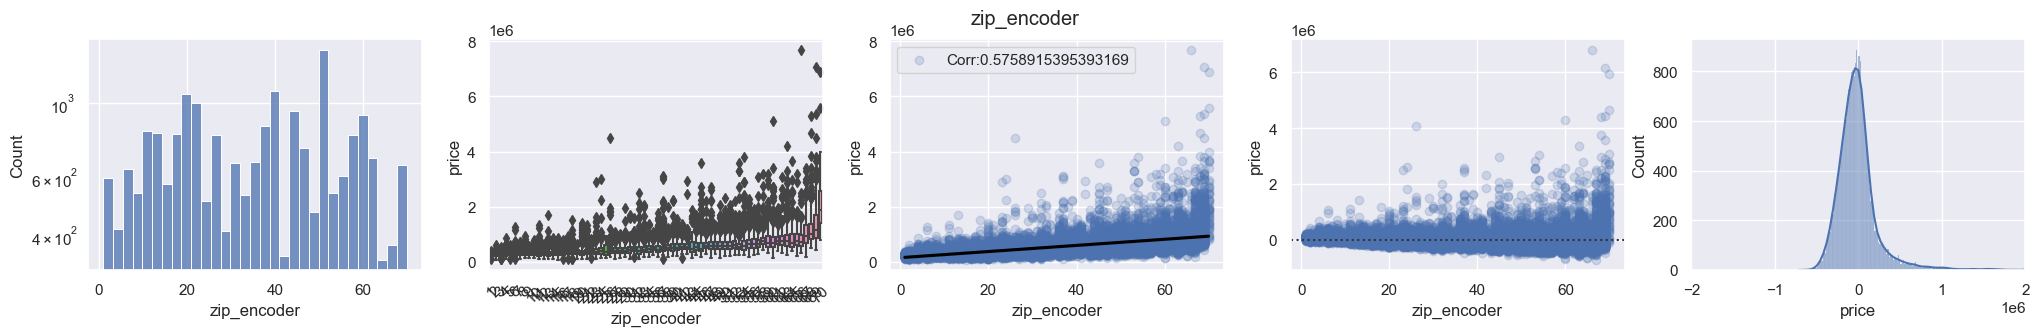

In [15]:
FeaturePlot(feature = 'zip_encoder', histwidth = None , scale = 'log', bin=len(df_zip))

### Summery
* Ordinal encoder of zipcode shows good correlation 0.58.
* It shows linear relation in the most of range except high price range. 
* I can try linear regression first and polynomial feature expansion and compare the model.

## Check multicollinearity between independent variables

Multicollinearity occurs when independent vatiables in mulrilinear regression model are linearly correlated. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

In general, multicollinearity can be detected by the variance inflation factor (VIF):
$$ VIF = \frac{1}{1-R^2} $$
where, $R^2$ is the coefficient of determination of a regression. VIF of 5 or 10 and above, indicates a multicollinearity problem.

There are several ways to reduce the multicollinearity.
1. Generate new feature based on existing independent variables.
2. Standardize or mean-center the independent variables.
3. Principal component regression (PCR) based on principal component analysis (PCA).
In this notebook, I determine the multicollinearity from the dataset by calculating VIF. 
I will use some of abave listed remedies to overcome the multicollinearity in the next step.

In [52]:
# import VIF function from statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
# define variables
features = ['bathrooms','grade','sqft_above', 'sqft_living15','zip_encoder']
X = df[features]

In [53]:
# Construct VIF dataframe
df_VIF = pd.DataFrame()
df_VIF['Feature'] = features

# Calculate VIF for each variables
df_VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
df_VIF

,Feature,VIF
0,bathrooms,17.715750
1,grade,26.542651
2,sqft_above,15.398978
3,sqft_living15,23.557256
4,zip_encoder,5.260702


### Summery
* Five independent variables are tested for VIF to detect multicollinearity.
* All of them shows >5 VIF, indicating there are some degrees of multicollinearity problem.
* Dropping the features with high VIF is not recommended due to the posibility of information loss.
* I will build model with and without correction to reduce the multicollinearity and compare the results.